# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())

# EDA

In [42]:
import glob
demo_path = "train/*/*.png"
size = []
paths = []
images = glob.glob(demo_path)
for image in images:
    img = imread(image)
    size.append(img.shape)
size

[(120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 160, 3),
 (120, 1

In [43]:
from collections import Counter
Counter(size)

Counter({(120, 160, 3): 14370, (360, 360, 3): 5520})

**Observation**
1. We can see that hieght and width is not matching for 14370 images. We can decrease the width by removing pixels from left and right.

(120, 160, 3)


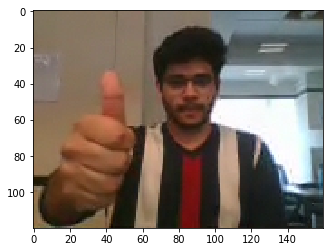

In [51]:
img160 = imread(images[10])
plt.imshow(img160)
print(img160.shape)

(360, 360, 3)


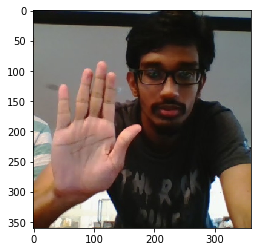

In [52]:
img360 = imread(images[90])
plt.imshow(img360)
print(img360.shape)

(120, 120, 3)


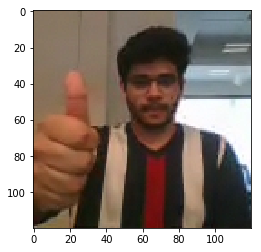

In [57]:
plt.imshow(img160[:,20:140,:])
print(img160[:,20:140,:].shape)

**Observation**
1. After removing 20 pixels from left and 20 pixels from right. We can see that we are able to crop the image without loosing much information.

(100, 100, 3)


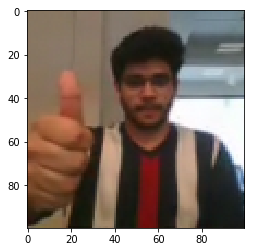

In [91]:
img100_reszied = imresize(img160[:,20:140,:], (100,100))
plt.imshow(img120_reszied)
print(img100_reszied.shape)

**Observation**
1. Tried with different shapes for resizing, 100x100 looks good and we don't loose much information.

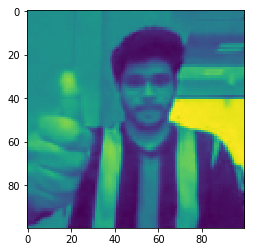

In [89]:
plt.imshow(img100_reszied[:,:,0])

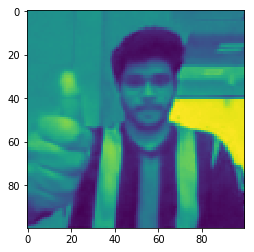

In [97]:
# Normalising and Visualzing
img100_reszied = img100_reszied.astype("float64")
img100_reszied[:,:,0] = (img100_reszied[:,:,0]-img100_reszied[:,:,0].mean()) /img100_reszied[:,:,0].std()
plt.imshow(img100_reszied[:,:,0])

In [98]:
img100_reszied[:,:,0], img160[:,20:140,0]

(array([[ 0.38794464,  0.35413756,  0.33723403, ..., -0.01774026,
         -0.01774026,  0.08368096],
        [ 0.35413756,  0.35413756,  0.35413756, ...,  0.01606681,
          0.1005845 , -0.06845088],
        [ 0.33723403,  0.35413756,  0.33723403, ...,  0.06677742,
          0.03297035, -0.42342516],
        ...,
        [-1.30240911, -1.37002326, -1.31931265, ..., -1.5221551 ,
         -1.5221551 , -1.5221551 ],
        [-1.15027728, -0.99814544, -0.7107853 , ..., -1.50525156,
         -1.5221551 , -1.50525156],
        [-0.06845088,  0.06677742,  0.03297035, ..., -1.5221551 ,
         -1.5221551 , -1.5221551 ]]),
 array([[137, 135, 134, ..., 110, 113, 122],
        [135, 135, 134, ..., 115, 121, 115],
        [134, 134, 134, ..., 122, 122,  92],
        ...,
        [ 37,  32,  28, ...,  24,  23,  23],
        [ 48,  61,  80, ...,  27,  24,  26],
        [123, 139, 119, ...,  24,  24,  24]], dtype=uint8))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [5, 8, 10, 12, 15, 18, 20, 22, 25]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Cropping 20 pixels from left and right for the images who are not in square size
                    # and then repshaping them into 84 x 84 size 
                    if image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(80,80)).astype(np.float32)
                    else:
                        image = imresize(image,(80,80)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - image[:,:,0].mean())/image[:,:,0].std()
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - image[:,:,1].mean())/image[:,:,1].std()
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - image[:,:,2].mean())/image[:,:,2].std()
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,80,80,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    if image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(80,80)).astype(np.float32)
                    else:
                        image = imresize(image,(80,80)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - image[:,:,0].mean())/image[:,:,0].std()
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - image[:,:,1].mean())/image[:,:,1].std()
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - image[:,:,2].mean())/image[:,:,2].std()

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [65]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [109]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,80,80,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
# model.add(Dropout(0.2))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [110]:
optimiser = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_73 (Conv3D)           (None, 18, 80, 80, 32)    2624      
_________________________________________________________________
batch_normalization_73 (Batc (None, 18, 80, 80, 32)    128       
_________________________________________________________________
activation_73 (Activation)   (None, 18, 80, 80, 32)    0         
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 9, 40, 40, 32)     0         
_________________________________________________________________
conv3d_74 (Conv3D)           (None, 9, 40, 40, 64)     55360     
_________________________________________________________________
batch_normalization_74 (Batc (None, 9, 40, 40, 64)     256       
_________________________________________________________________
activation_74 (Activation)   (None, 9, 40, 40, 64)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [111]:
batch_size = 64
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [112]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [113]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [114]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 64
Source path =  train ; batch size = 64
Epoch 1/30
11/11 [==============================] - 33s 3s/step - loss: 3.1558 - categorical_accuracy: 0.2618 - val_loss: 1.6182 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2021-02-0103_34_01.652964/model-00001-3.19542-0.25943-1.61819-0.29000.h5
Epoch 2/30
11/11 [==============================] - 19s 2s/step - loss: 2.1835 - categorical_accuracy: 0.2575 - val_loss: 1.5812 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2021-02-0103_34_01.652964/model-00002-2.21870-0.25490-1.58119-0.40000.h5
Epoch 3/30
11/11 [==============================] - 24s 2s/step - loss: 1.6710 - categorical_accuracy: 0.3288 - val_loss: 1.4820 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2021-02-0103_34_01.652964/model-00003-1.69487-0.32278-1.48196-0.30000.h5
Epoch 4/30
11/11 [==============================] - 24s 2s/step - loss: 1.6291 - categoric

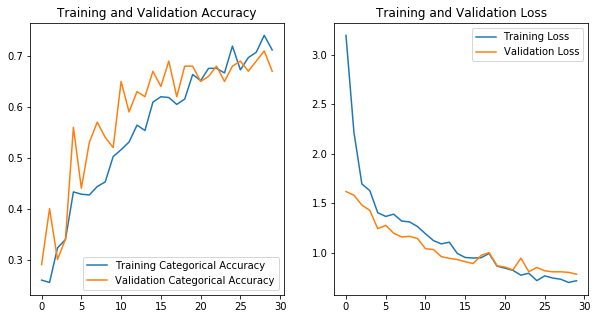

In [115]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ConvGRU

In [122]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [5, 8, 10, 12, 15, 18, 20, 22, 25]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Cropping 20 pixels from left and right for the images who are not in square size
                    # and then repshaping them into 84 x 84 size 
                    if image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - image[:,:,0].mean())/image[:,:,0].std()
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - image[:,:,1].mean())/image[:,:,1].std()
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - image[:,:,2].mean())/image[:,:,2].std()
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    if image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - image[:,:,0].mean())/image[:,:,0].std()
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - image[:,:,1].mean())/image[:,:,1].std()
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - image[:,:,2].mean())/image[:,:,2].std()

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [126]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [119]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(18,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [120]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, 18, 64)            15009664  
_________________________________________________________________
gru_30 (GRU)                 (None, 18, 32)            9312      
_________________________________________________________________
gru_31 (GRU)                 (None, 16)                2352      
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_54 (Dense)             (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [111]:
batch_size=16
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [112]:
model_name = 'model_init_convlstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [113]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [90]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 16
Source path =  train ; batch size = 16
Epoch 1/50
42/42 [==============================] - 49s 1s/step - loss: 1.6942 - categorical_accuracy: 0.2296 - val_loss: 1.5765 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_convlstm_2021-02-0116_05_59.408232/model-00001-1.69607-0.23077-1.57646-0.29000.h5
Epoch 2/50
42/42 [==============================] - 35s 829ms/step - loss: 1.5772 - categorical_accuracy: 0.2620 - val_loss: 1.5513 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model_init_convlstm_2021-02-0116_05_59.408232/model-00002-1.57499-0.26546-1.55128-0.29000.h5
Epoch 3/50
42/42 [==============================] - 35s 831ms/step - loss: 1.5166 - categorical_accuracy: 0.2914 - val_loss: 1.5075 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_convlstm_2021-02-0116_05_59.408232/model-00003-1.51646-0.28959-1.50745-0.33000.h5
Epoch 4/50
42/42 [==============================] - 35s 8

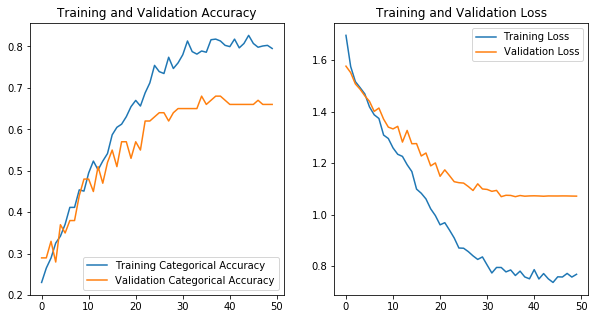

In [91]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ConvGRU model 2

In [121]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(18,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.7))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [122]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, 18, 64)            15009664  
_________________________________________________________________
gru_32 (GRU)                 (None, 18, 32)            9312      
_________________________________________________________________
gru_33 (GRU)                 (None, 16)                2352      
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_57 (Dense)             (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [117]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [123]:
batch_size=16
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [124]:
model_name = 'model_init_convlstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [125]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [114]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 16
Source path =  train ; batch size = 16
Epoch 1/25
42/42 [==============================] - 50s 1s/step - loss: 1.7441 - categorical_accuracy: 0.2132 - val_loss: 1.5694 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_convlstm_2021-02-0116_43_25.001090/model-00001-1.74370-0.21418-1.56937-0.29000.h5
Epoch 2/25
42/42 [==============================] - 35s 832ms/step - loss: 1.6925 - categorical_accuracy: 0.2155 - val_loss: 1.5918 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_convlstm_2021-02-0116_43_25.001090/model-00002-1.69186-0.21267-1.59182-0.25000.h5
Epoch 3/25
42/42 [==============================] - 35s 829ms/step - loss: 1.6237 - categorical_accuracy: 0.2579 - val_loss: 1.5370 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_convlstm_2021-02-0116_43_25.001090/model-00003-1.62333-0.25943-1.53702-0.33000.h5
Epoch 4/25
42/42 [==============================] - 36s 8

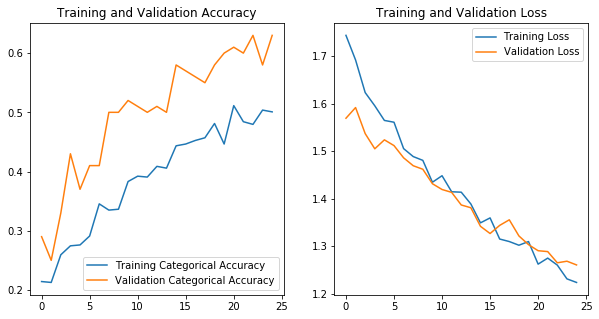

In [115]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()